In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

#keras
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        #print(os.path.join(dirname, filename))
        

dataset_path = '/kaggle/input/petfinder-pawpularity-score/'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Taking a look at the Data - (EDA)**

In [2]:
train_df = pd.read_csv(dataset_path + 'train.csv')
test_df = pd.read_csv(dataset_path + 'test.csv')
submission_df = pd.read_csv(dataset_path + 'sample_submission.csv')

train_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  
0          0      1        0      0          0     0     0           63  
1          0      0        0      0          0     0     0           42  
2          0      0        0      1          1     0     0           28  
3          0      0        0      0          0     0     0           15  
4          0      1        0      0          0     0     0           72

In [3]:
submission_df.head()

Id  Pawpularity
0  4128bae22183829d2b5fea10effdb0c3        67.75
1  43a2262d7738e3d420d453815151079e        59.15
2  4e429cead1848a298432a0acad014c9d        20.02
3  80bc3ccafcc51b66303c2c263aa38486        94.53
4  8f49844c382931444e68dffbe20228f4        89.82

In [4]:
test_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  4128bae22183829d2b5fea10effdb0c3              1     0     1     0       0   
1  43a2262d7738e3d420d453815151079e              0     1     0     0       0   
2  4e429cead1848a298432a0acad014c9d              0     0     0     1       0   
3  80bc3ccafcc51b66303c2c263aa38486              1     0     1     0       0   
4  8f49844c382931444e68dffbe20228f4              1     1     1     0       1   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  
0          1      1        0      0          1     0     1  
1          0      1        1      0          0     0     0  
2          1      1        1      0          1     1     1  
3          0      0        0      0          0     1     0  
4          1      0        1      0          1     1     0

In [5]:
# Add image path to the dataset

train_df['Img'] = train_df['Id'].map(lambda x: str(dataset_path + 'train/' + x + '.jpg'))
# train_df = train_df.drop(columns=['Id']) - keeping the ID of the test data. Would be useful for submission

test_df['Img'] = test_df['Id'].map(lambda x: str(dataset_path + 'test/' + x + '.jpg'))
# test_df = test_df.drop(columns=['Id']) - keeping the ID of the test data. Would be useful for submission

train_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                 Img  
0  /kaggle/input/petfinder-pawpularity-score/trai...  
1  /kaggle/input/petfinder-pawpularity-score/trai...  
2  /kaggle/input/petfinder-pawpularity-score/trai...  
3  /kaggle/input/petfinder-pawpularity-score/trai...  
4  /kaggle/input/petfinder-pawpularity-score/trai...

**Checkiing out the distribution of the target variable - Pawpularity**

In [6]:
train_df['Pawpularity'].describe()

count    9912.000000
mean       38.039044
std        20.591990
min         1.000000
25%        25.000000
50%        33.000000
75%        46.000000
max       100.000000
Name: Pawpularity, dtype: float64

<AxesSubplot:>

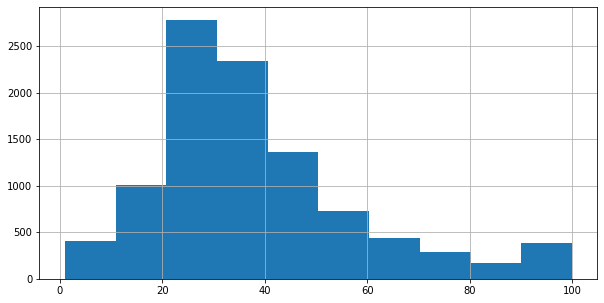

In [7]:
train_df['Pawpularity'].hist(figsize=(10,5))

The above looks skewed

**Checking to see the distribution**

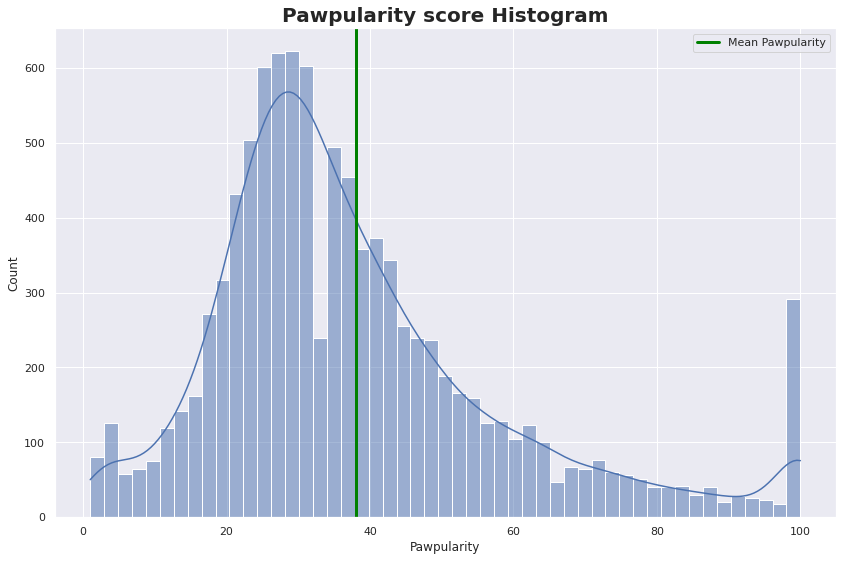

In [8]:
sns.set(rc={'figure.figsize':(14,9)})

fig = plt.figure()
sns.histplot(data=train_df, x='Pawpularity', kde=True)
plt.axvline(train_df['Pawpularity'].mean(), c='green', ls='-', lw=3, label="Mean Pawpularity")
plt.title('Pawpularity score Histogram', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

This is not sufficient to say if the data is normally distributed as it is centered around 38. We will check the normality of the distribution with a quantile - quantile diagram.

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 1008x648 with 0 Axes>

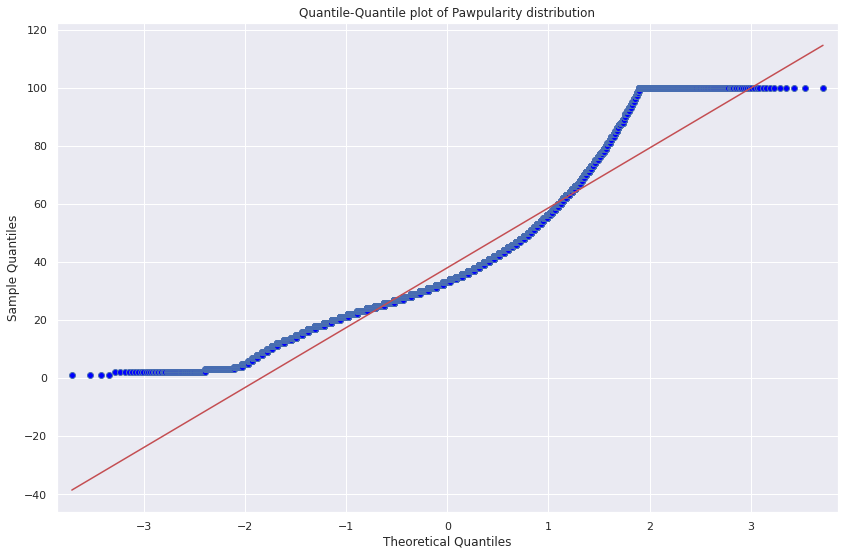

In [9]:
from statsmodels.graphics.gofplots import qqplot

fig = plt.figure()
qqplot(train_df['Pawpularity'], line='s')
plt.title('Quantile-Quantile plot of Pawpularity distribution')
plt.show()

From the QQPlot above, we can also see the target column is not normally distributed. We will now check with the Kolmogorov-Smirnov test to further confirm

In [10]:
from scipy.stats import kstest

stat, p = kstest(train_df['Pawpularity'],'norm')
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print(f'Data seem Gaussian. We will not reject H0 at {int(alpha*100)}% test level')
else:
    print(f'Data is not Gaussian We will reject H0 at {int(alpha*100)}% test level')

Statistics=0.990, p=0.000
Data is not Gaussian We will reject H0 at 5% test level


**Let us now take a look at the distribution of the rest of the parameters**

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
 14  Img            9912 non-null   object
dtypes: int64(13), object(2)
memory usage: 1.1+ MB


**There are no missing values**

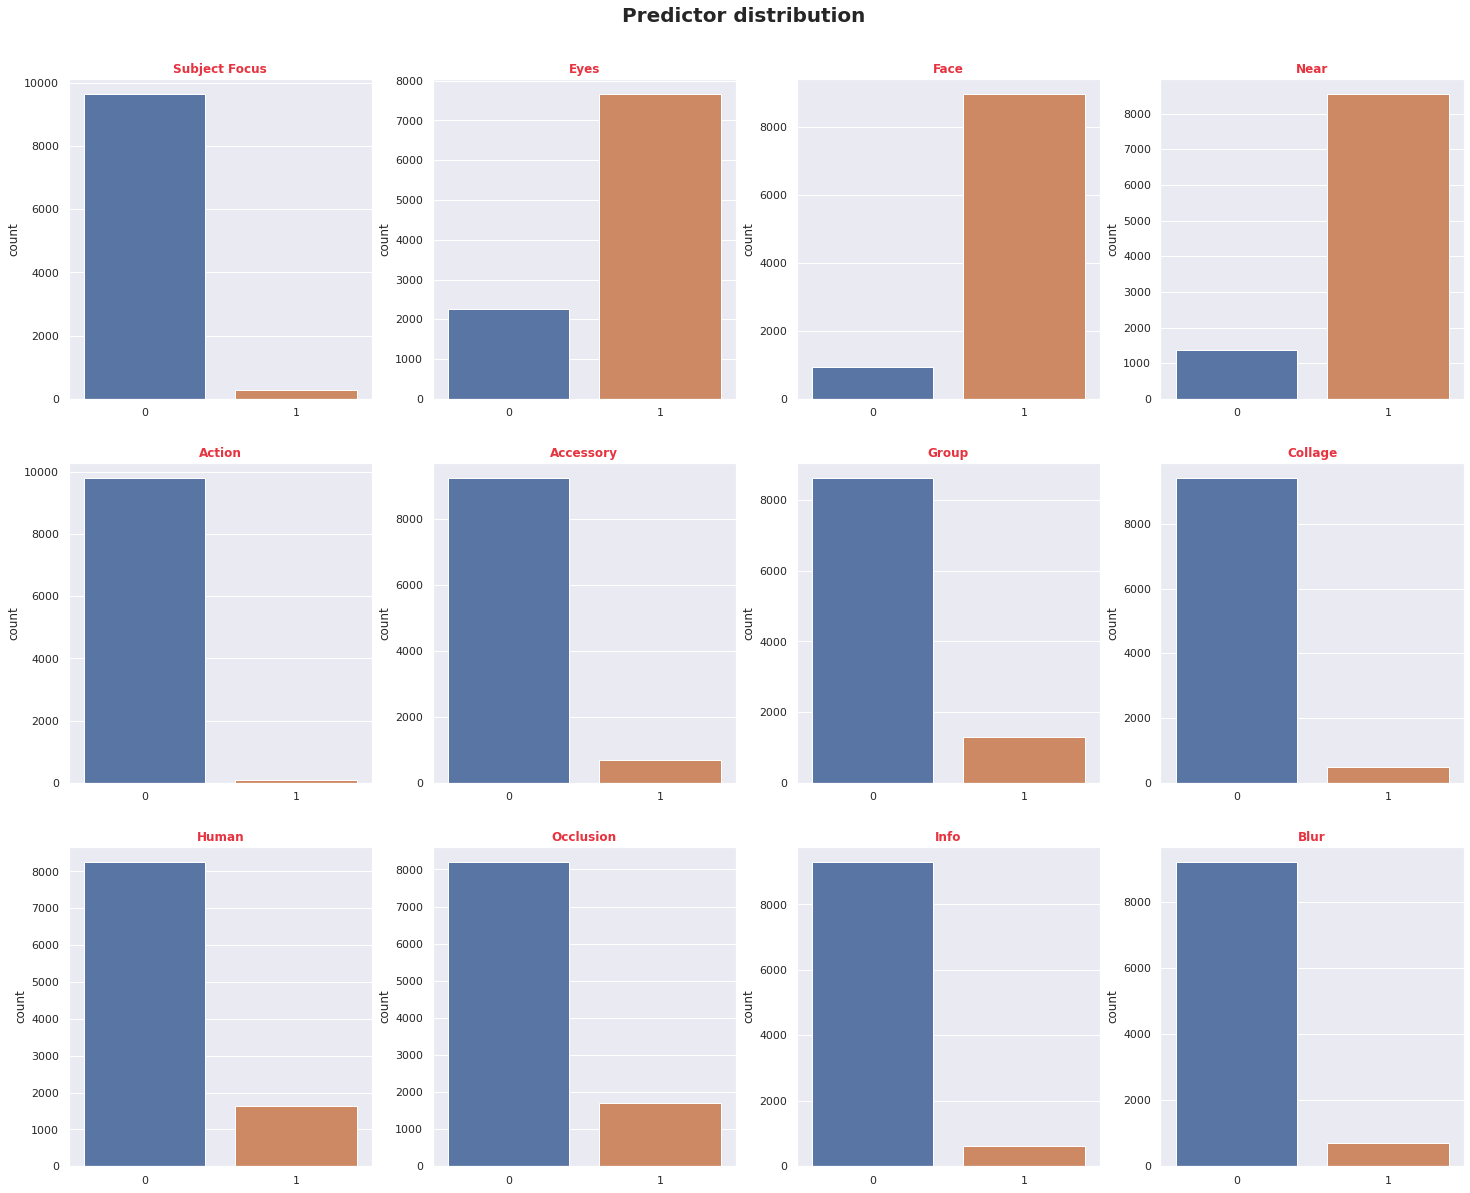

In [12]:
predictor = train_df.columns[1:-2]

fig = plt.figure(figsize=(25,20))
for i, x in enumerate(predictor):
    ax = plt.subplot(3,4,i+1)
    sns.countplot(data=train_df, x=x, ax=ax)
    ax.set_xlabel(None)
    ax.set_title(x, fontweight='bold', color="#e7323f")

plt.suptitle("Predictor distribution", y=0.93,
             fontsize=20, fontweight='bold')
plt.show()  

<AxesSubplot:>

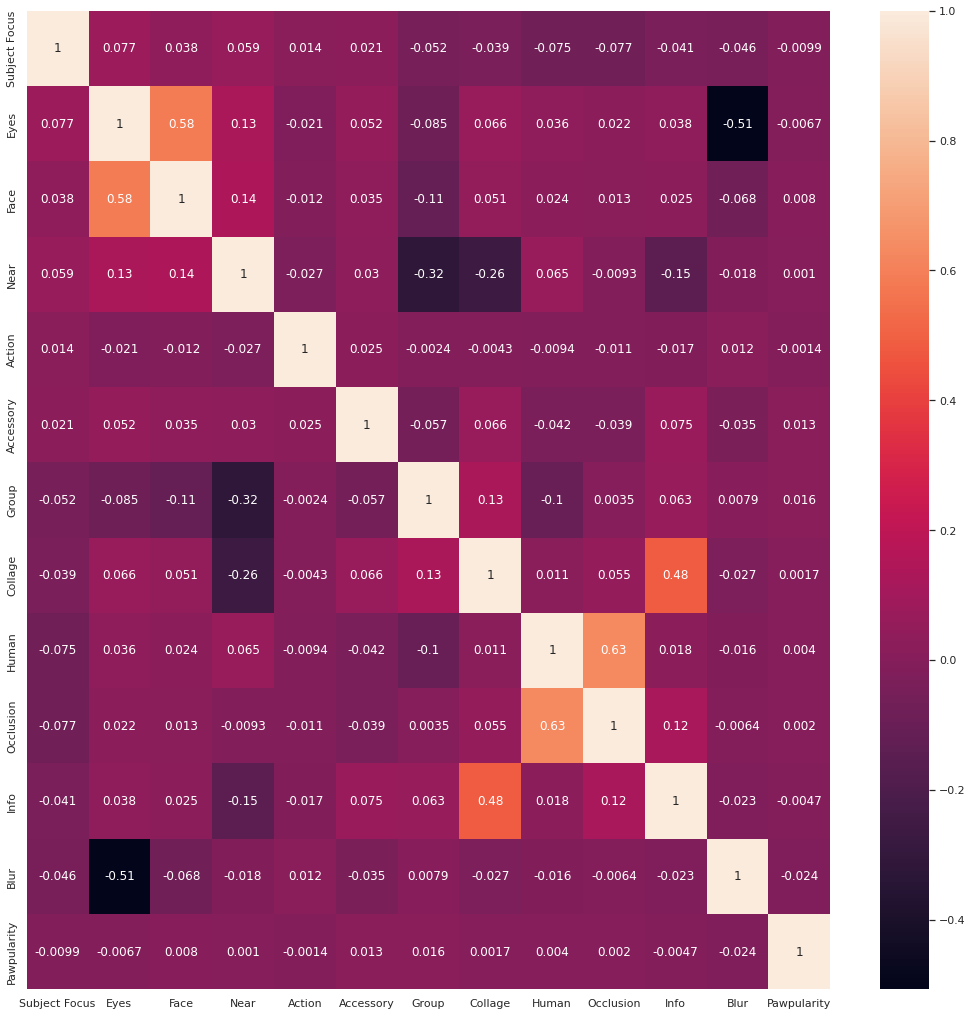

In [13]:
# Lets take a look at the heatmap of the dataset
fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train_df[:-1].corr(),annot=True)

From the above, we can see there is a bit of high correlation (>0.5) between Eyes and Face, and Occlusion and Human. Info and Collage also come close but not up to 0.5

We, therefore also need to check if there is too much multicollinearity that could degrade the performance of our models. For this we will use Variance Inflation Factor (VIF) from Statsmodel

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = train_df[predictor]
vif["Feature"] = X.columns
  
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]  
vif = vif.sort_values("VIF", ascending=False)
vif

Feature        VIF
2            Face  13.715668
1            Eyes  10.118170
3            Near   5.762924
9       Occlusion   2.073562
8           Human   2.064939
11           Blur   1.595109
7         Collage   1.452023
10           Info   1.412621
6           Group   1.163850
5       Accessory   1.090942
0   Subject Focus   1.048292
4          Action   1.010174

From the table above, Face and Eyes have very high values of VIF, which means both parameters are highly correlated. Hence, having the 2 pramters together in our model will lead to a model with high multicollinearity. To avoid this, we will have to use only one of the 2 parameters.

We remove the column(Parameter) with the highest VIF.

In [15]:
X.drop("Face", axis=1, inplace=True)
X.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Subject Focus  Eyes  Near  Action  Accessory  Group  Collage  Human  \
0              0     1     1       0          0      1        0      0   
1              0     1     0       0          0      0        0      0   
2              0     1     1       0          0      0        0      1   
3              0     1     1       0          0      0        0      0   
4              0     0     1       0          0      1        0      0   

   Occlusion  Info  Blur  
0          0     0     0  
1          0     0     0  
2          1     0     0  
3          0     0     0  
4          0     0     0

**Correlations between predictor variables and Pawpularity**

We will now check whether there are strong linear correlations (Pearson) between the predictor variables and the variable to be predicted (Pawpularity).

In [16]:
for x in X.columns:
    corr_y = round(np.corrcoef(train_df[x], train_df["Pawpularity"])[0,1],4)
    print(f"Pawpularity - {x}: {corr_y}")

Pawpularity - Subject Focus: -0.0099
Pawpularity - Eyes: -0.0067
Pawpularity - Near: 0.001
Pawpularity - Action: -0.0014
Pawpularity - Accessory: 0.0133
Pawpularity - Group: 0.0165
Pawpularity - Collage: 0.0017
Pawpularity - Human: 0.004
Pawpularity - Occlusion: 0.002
Pawpularity - Info: -0.0047
Pawpularity - Blur: -0.0235


From the above, there seem to be no correlation between the target variable and the other parameters.

**Taking a look at a sample Images**

In [17]:
from PIL import Image

im = Image.open(train_df['Img'][15])
width, height = im.size
print(width,height)

720 960


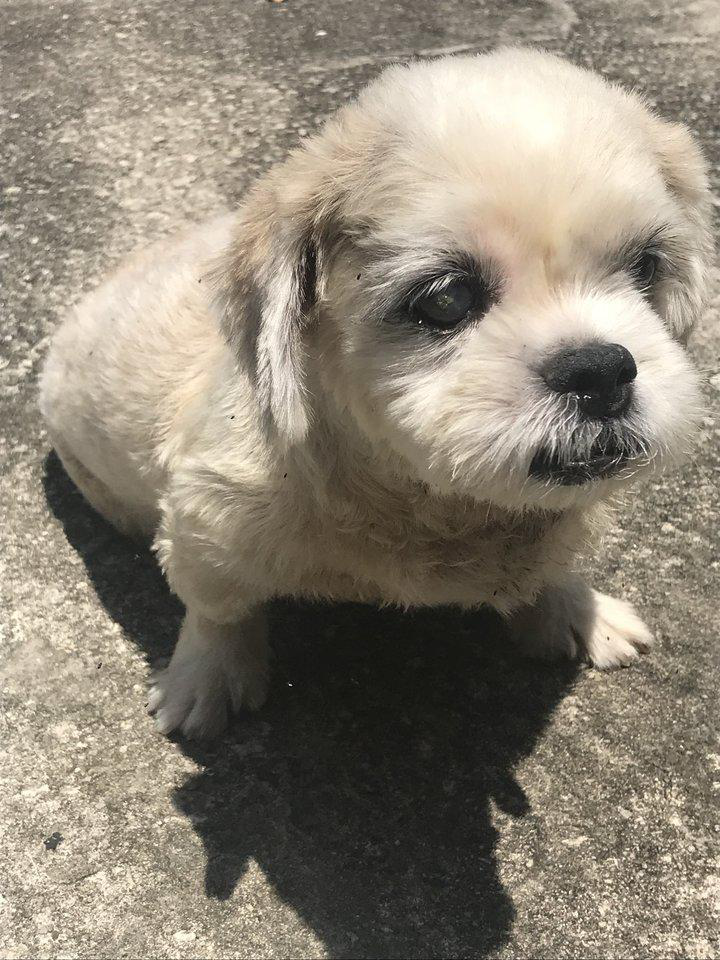

In [18]:
im

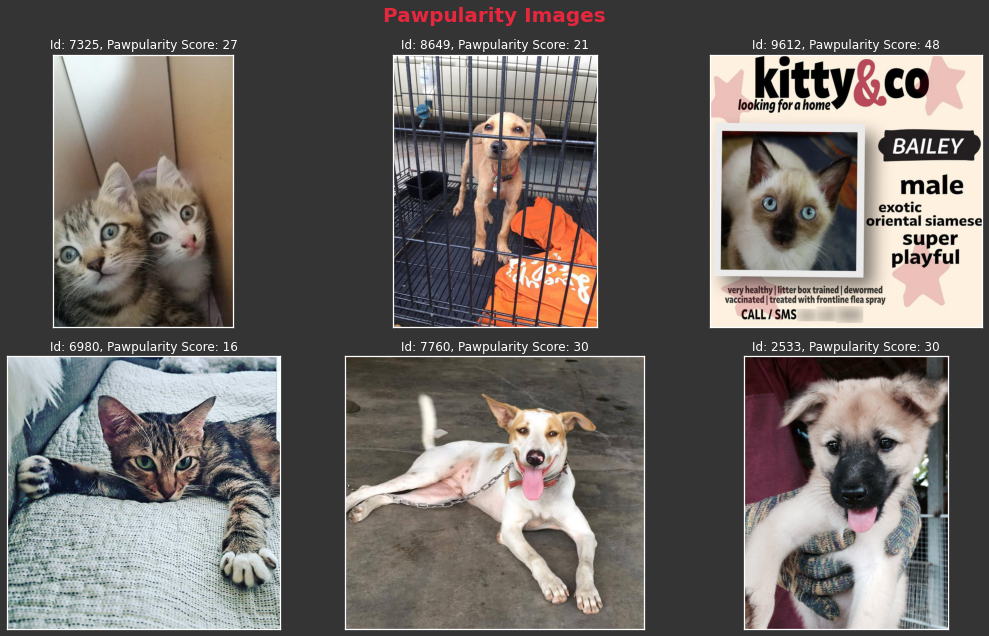

In [19]:
fig, ax = plt.subplots(2,3,figsize=(15,9))
fig.patch.set_facecolor('#343434')

for i, a in zip(train_df[['Img', 'Pawpularity']].sample(6).iterrows(), ax.ravel()):
    a.set(xticks=[], yticks=[])
    img = plt.imread(i[1][0])
    a.imshow(img)
    a.set_title(f'Id: {i[0]}, Pawpularity Score: {i[1][1]}', color="white")

fig.suptitle('Pawpularity Images', fontsize=20, fontweight='bold', color="#e7273e")
fig.tight_layout()
fig.show()

**Let us look at 3 of the most popular and 3 of the least popular to see if there are any physical difference**

In [20]:
top = train_df[train_df['Pawpularity'] == 100]['Img']
top

19      /kaggle/input/petfinder-pawpularity-score/trai...
50      /kaggle/input/petfinder-pawpularity-score/trai...
86      /kaggle/input/petfinder-pawpularity-score/trai...
182     /kaggle/input/petfinder-pawpularity-score/trai...
227     /kaggle/input/petfinder-pawpularity-score/trai...
                              ...                        
9684    /kaggle/input/petfinder-pawpularity-score/trai...
9725    /kaggle/input/petfinder-pawpularity-score/trai...
9836    /kaggle/input/petfinder-pawpularity-score/trai...
9843    /kaggle/input/petfinder-pawpularity-score/trai...
9878    /kaggle/input/petfinder-pawpularity-score/trai...
Name: Img, Length: 288, dtype: object

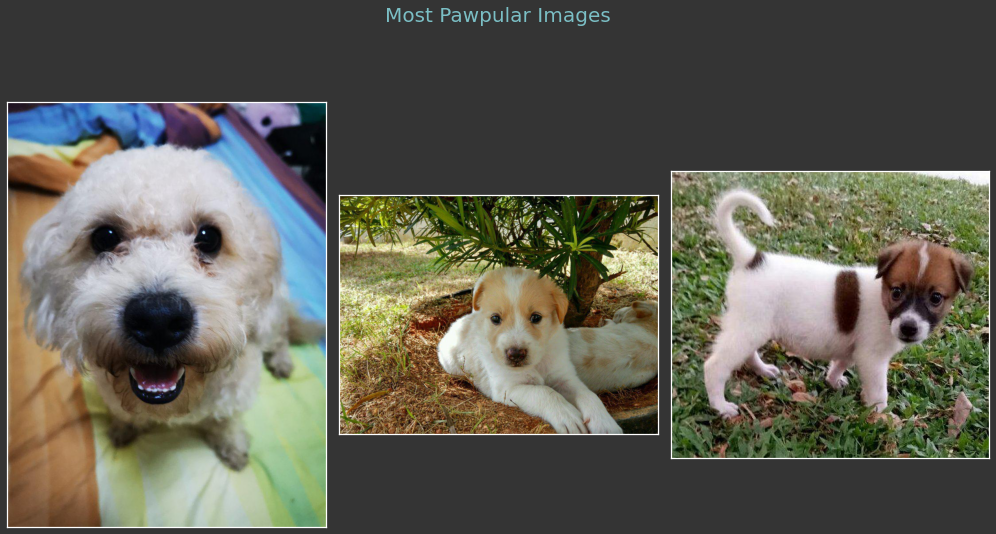

In [21]:
top = train_df[train_df['Pawpularity'] == 100]['Img']

fig, ax = plt.subplots(1,3)
fig.patch.set_facecolor('#343434')

for i, ax in zip(top.sample(3), ax.ravel()):
    ax.set(xticks=[], yticks=[])
    img = plt.imread(i)
    ax.imshow(img)
    
fig.suptitle('Most Pawpular Images', fontsize=20, color='#7bbfc5', y=0.95)
fig.tight_layout()
fig.show()

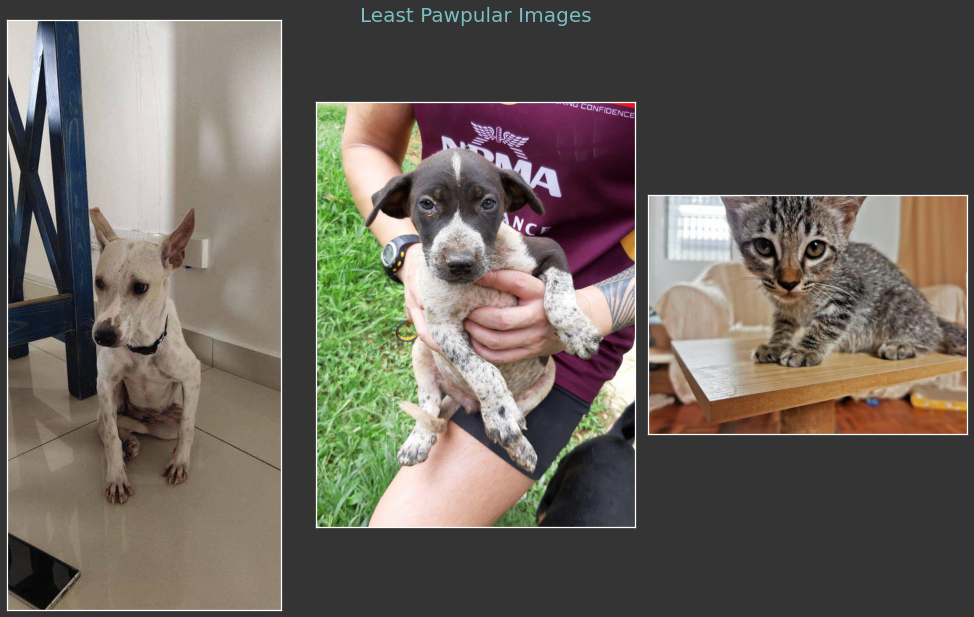

In [22]:
bottom = train_df[train_df['Pawpularity'] == 1]['Img']

fig, ax = plt.subplots(1,3)
fig.patch.set_facecolor('#343434')

for i, ax in zip(bottom.sample(3), ax.ravel()):
    ax.set(xticks=[], yticks=[])
    img = plt.imread(i)
    ax.imshow(img)
    
fig.suptitle('Least Pawpular Images', fontsize=20, color='#7bbfc5', y=0.95)
fig.tight_layout()
fig.show()

# Feature Engineering

Since we are predicting the popularity of pictures, we will therefore extract features that can help determine (increase or decrease) the likeness or popularity of the pictures such as the background or dominant color.

We will start with extracting the dominant colors of the images and store as a parameter.
We will be using clustering methods on the RGB layers of our image files to extract the dominant color in HLS (Hue Lightness Saturation) format. This format will allow us to recover in a single formula the information on the hue, saturation and luminance of the dominant color of each image.

In [23]:
from sklearn.cluster import KMeans
from collections import Counter
import cv2


def get_dominant_color(image_path, k=4, image_processing_size = None):
    """
    takes an image as input
    returns the dominant color of the image as a list
    
    dominant color is found by running k means on the 
    pixels & returning the centroid of the largest cluster

    processing time is speed up by working with a smaller image; 
    this resizing can be done with the image_processing_size param 
    which takes a tuple of image dims as input
    """
    
    image = plt.imread(image_path)
    #resize image if new dims provided
    if image_processing_size is not None:
        image = cv2.resize(image, image_processing_size, 
                            interpolation = cv2.INTER_AREA)
    
    #reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    #cluster and assign labels to the pixels 
    clt = KMeans(n_clusters = k)
    labels = clt.fit_predict(image)

    #count labels to find most popular
    label_counts = Counter(labels)

    #subset out most popular centroid
    dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]
    dominant_color = list(dominant_color)
    r = int(dominant_color[0])
    g = int(dominant_color[1])
    b = int(dominant_color[2])
    
    #Convert to HLS color space
    dominant_hls = colorsys.rgb_to_hls(r, g, b)

    return list(dominant_hls)

Taking a look at sample Image

Dominant HLS :  [0.09459459459459459, 119.5, -0.15611814345991562]
Dominant Color Hex :  #8a7a65


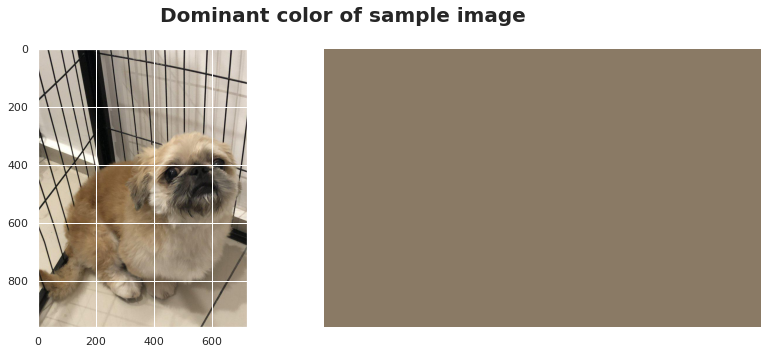

In [24]:
import colorsys
import matplotlib

sample_img = train_df['Img'][103]
sample_hls = get_dominant_color(sample_img, k=3, image_processing_size = (50, 50))
sample_dom_color = colorsys.hls_to_rgb(sample_hls[0],
                                       sample_hls[1],
                                       sample_hls[2])
sample_dom_color = "#{:02x}{:02x}{:02x}".format(int(sample_dom_color[0]),
                                                int(sample_dom_color[1]),
                                                int(sample_dom_color[2]))
print("Dominant HLS : ", sample_hls)
print("Dominant Color Hex : ", sample_dom_color)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax = plt.imshow(plt.imread(sample_img))
ax2 = fig.add_subplot(122)
rect1 = matplotlib.patches.Rectangle((0,0), 10, 5,color=sample_dom_color)
ax2.add_patch(rect1)
plt.axis('off')
plt.suptitle('Dominant color of sample image', fontsize=20, fontweight='bold', y=0.98)
fig.tight_layout()
plt.show()

Applying to all images

In [25]:
from tqdm.notebook import tqdm

tqdm.pandas()
train_df['Dominant_color_hls'] = train_df['Img'].progress_apply(lambda x: get_dominant_color(x, k=3, image_processing_size = (50, 50)))

  0%|          | 0/9912 [00:00<?, ?it/s]

In [26]:
train_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                 Img  \
0  /kaggle/input/petfinder-pawpularity-score/trai...   
1  /kaggle/input/petfinder-pawpularity-score/trai...   
2  /kaggle/input/petfinder-pawpularity-score/trai...   
3  /kaggle/input/petfinder-pawpularity-score/trai...   
4  /kaggle/input/petfinder-pawpularity-score/trai...   

                                  Dominant_color_hls  
0  [0.08333333333333333, 174.0, -0.01156069364161...  
1   [0.05555555555555556, 48.0, -0.2553191489361702]  
2   [0.4934640522875817, 84.5, -0.30538922155688625]  
3  [0.0925925925925926, 154.5, -0.029315960912052...  
4  [0.08333333333333333, 136.0, -0.04444444444444...

In [27]:
temp_train_df = train_df["Dominant_color_hls"].apply(pd.Series)
temp_train_df = temp_train_df.rename(columns={0:"H",1:"L",2:"S"})
train_df = pd.concat([train_df, temp_train_df], axis=1)
train_df.drop("Dominant_color_hls", axis=1, inplace=True)
train_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                 Img         H      L  \
0  /kaggle/input/petfinder-pawpularity-score/trai...  0.083333  174.0   
1  /kaggle/input/petfinder-pawpularity-score/trai...  0.055556   48.0   
2  /kaggle/input/petfinder-pawpularity-score/trai...  0.493464   84.5   
3  /kaggle/input/petfinder-pawpularity-score/trai...  0.092593  154.5   
4  /kaggle/input/petfinder-pawpularity-score/trai...  0.083333  136.0   

          S  
0 -0.011561  
1 -0.255319  
2 -0.305389  
3 -0.029316  
4 -0.044444

Looking at the distribution of H, L, S

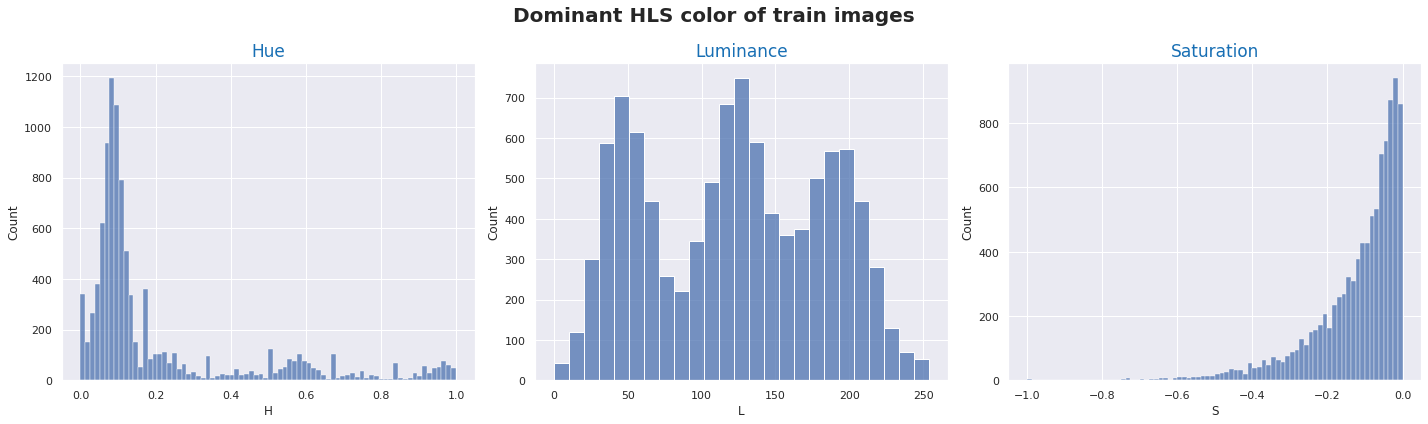

In [28]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(131)
sns.histplot(train_df["H"], ax=ax1)
ax1.set_title("Hue", fontsize=17, color="#186fb4")
ax2 = fig.add_subplot(132)
sns.histplot(train_df["L"], ax=ax2)
ax2.set_title("Luminance", fontsize=17, color="#186fb4")
ax3 = fig.add_subplot(133)
sns.histplot(train_df["S"], ax=ax3)
ax3.set_title("Saturation", fontsize=17, color="#186fb4")
plt.suptitle('Dominant HLS color of train images', 
             fontsize=20, fontweight='bold', y=0.98)
fig.tight_layout()
plt.show()

In [29]:
test_df["Dominant_color_hls"] = test_df["Img"].progress_apply(
    lambda x : get_dominant_color(
        x, 
        k=3, 
        image_processing_size = (50, 50)))

  0%|          | 0/8 [00:00<?, ?it/s]

In [30]:
temp_test_df = test_df["Dominant_color_hls"].apply(pd.Series)
temp_test_df = temp_test_df.rename(columns={0:"H",1:"L",2:"S"})
test_df = pd.concat([test_df, temp_test_df], axis=1)
test_df.drop("Dominant_color_hls", axis=1, inplace=True)
test_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  4128bae22183829d2b5fea10effdb0c3              1     0     1     0       0   
1  43a2262d7738e3d420d453815151079e              0     1     0     0       0   
2  4e429cead1848a298432a0acad014c9d              0     0     0     1       0   
3  80bc3ccafcc51b66303c2c263aa38486              1     0     1     0       0   
4  8f49844c382931444e68dffbe20228f4              1     1     1     0       1   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0          1      1        0      0          1     0     1   
1          0      1        1      0          0     0     0   
2          1      1        1      0          1     1     1   
3          0      0        0      0          0     1     0   
4          1      0        1      0          1     1     0   

                                                 Img         H      L  \
0  /kaggle/input/petfinder-pawpularity-score/test...  0.946078  133.0   
1  /kaggle/input/petfinder-pawpularity-score/test...  0.077778  113.5   
2  /kaggle/input/petfinder-pawpularity-score/test...  0.210526  112.5   
3  /kaggle/input/petfinder-pawpularity-score/test...  0.041667  115.0   
4  /kaggle/input/petfinder-pawpularity-score/test...  0.026882  132.5   

          S  
0 -0.128788  
1 -0.066667  
2 -0.085202  
3 -0.070175  
4 -0.117871

**Resizing Images**

We will have to perform resize to obtain input_shape conforming to what the models we will be running expect. We are therefore going to save the initial size of the image in a variable. This could also have an impact on the popularity of the photo.

In [31]:
def get_img_size(path):
    width = []
    height = []
    landscape = []
    for image_path in tqdm(os.listdir(path)):
        image = plt.imread(path+image_path)
        width.append(image.shape[1])
        height.append(image.shape[0])
        if(image.shape[1] > image.shape[0]):
            landscape_img = 1
        else:
            landscape_img = 0
        landscape.append(landscape_img)
    return width, height, landscape

In [32]:
TRAIN_PATH = "../input/petfinder-pawpularity-score/train/"
TEST_PATH = "../input/petfinder-pawpularity-score/test/"

train_df['Width'], train_df['Heihgt'], train_df['Landscape'] = get_img_size(TRAIN_PATH)

  0%|          | 0/9912 [00:00<?, ?it/s]

In [33]:
train_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  ...  Info  Blur  Pawpularity  \
0          0      1        0      0  ...     0     0           63   
1          0      0        0      0  ...     0     0           42   
2          0      0        0      1  ...     0     0           28   
3          0      0        0      0  ...     0     0           15   
4          0      1        0      0  ...     0     0           72   

                                                 Img         H      L  \
0  /kaggle/input/petfinder-pawpularity-score/trai...  0.083333  174.0   
1  /kaggle/input/petfinder-pawpularity-score/trai...  0.055556   48.0   
2  /kaggle/input/petfinder-pawpularity-score/trai...  0.493464   84.5   
3  /kaggle/input/petfinder-pawpularity-score/trai...  0.092593  154.5   
4  /kaggle/input/petfinder-pawpularity-score/trai...  0.083333  136.0   

          S  Width  Heihgt  Landscape  
0 -0.011561    720     960          0  
1 -0.255319    405     720          0  
2 -0.305389    315     514          0  
3 -0.029316   1280    1280          0  
4 -0.044444    720     960          0  

[5 rows x 21 columns]

In [34]:
test_df['Width'], test_df['Heihgt'], test_df['Landscape'] = get_img_size(TEST_PATH)

test_df.head()

  0%|          | 0/8 [00:00<?, ?it/s]

Id  Subject Focus  Eyes  Face  Near  Action  \
0  4128bae22183829d2b5fea10effdb0c3              1     0     1     0       0   
1  43a2262d7738e3d420d453815151079e              0     1     0     0       0   
2  4e429cead1848a298432a0acad014c9d              0     0     0     1       0   
3  80bc3ccafcc51b66303c2c263aa38486              1     0     1     0       0   
4  8f49844c382931444e68dffbe20228f4              1     1     1     0       1   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0          1      1        0      0          1     0     1   
1          0      1        1      0          0     0     0   
2          1      1        1      0          1     1     1   
3          0      0        0      0          0     1     0   
4          1      0        1      0          1     1     0   

                                                 Img         H      L  \
0  /kaggle/input/petfinder-pawpularity-score/test...  0.946078  133.0   
1  /kaggle/input/petfinder-pawpularity-score/test...  0.077778  113.5   
2  /kaggle/input/petfinder-pawpularity-score/test...  0.210526  112.5   
3  /kaggle/input/petfinder-pawpularity-score/test...  0.041667  115.0   
4  /kaggle/input/petfinder-pawpularity-score/test...  0.026882  132.5   

          S  Width  Heihgt  Landscape  
0 -0.128788    128     128          0  
1 -0.066667    128     128          0  
2 -0.085202    128     128          0  
3 -0.070175    128     128          0  
4 -0.117871    128     128          0

**Final Training Data**

We will now define the final dataset. 
Remember we agreeed to remove Face due to the high multicollinearity.
Also, remember our target variable - Pawpularity is not normally distributed, hence we will normalise by dividing by 100

In [35]:
img = train_df[["Img"]].values
y = np.ravel(train_df[["Pawpularity"]]/100)
X = train_df.drop(["Id","Img", "Face", "Pawpularity"], axis=1)
X_test = test_df.drop(["Id", "Face", "Img"], axis=1)

In [36]:
# Normalization

from sklearn.preprocessing import StandardScaler, MinMaxScaler

encoder = MinMaxScaler()
encoder.fit(X)
X_scaled = encoder.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_test_scaled = encoder.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

**Now we will use RandomForest to determine feature importance and GridSearchCV to find best hypeparameter**

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=38)

print(f'X_train: {X_train.shape}')
print(f'X_valid: {X_valid.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_valid: {y_valid.shape}')

X_train: (7929, 17)
X_valid: (1983, 17)
y_train: (7929,)
y_valid: (1983,)


In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

regressor = RandomForestRegressor(random_state=8)
param_grid = {
            "n_estimators" : [10,20,50,75,100,150],
            "max_features" : ["log2", "sqrt"],
            "max_depth"    : [5,10,15,25,35,50],
            "bootstrap"    : [True, False]
        }

grid_reg = GridSearchCV(
    regressor,
    param_grid,
    cv = 5,
    verbose=1,
    n_jobs=-1)

best_reg = grid_reg.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  6.5min finished


In [39]:
print(f"The best parameters for the model is: \n {best_reg.best_params_}")

The best parameters for the model is: 
 {'bootstrap': True, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 150}


**Save the Best Parameter model**

In [40]:
import pickle

with open('best_randforst_param.sav', 'wb') as best_randforst_param:
    pickle.dump(best_reg, best_randforst_param)
    
    

# loaded_model = pickle.load(open(filename, 'rb'))

Now, we will plot the importance of features in the modeling:

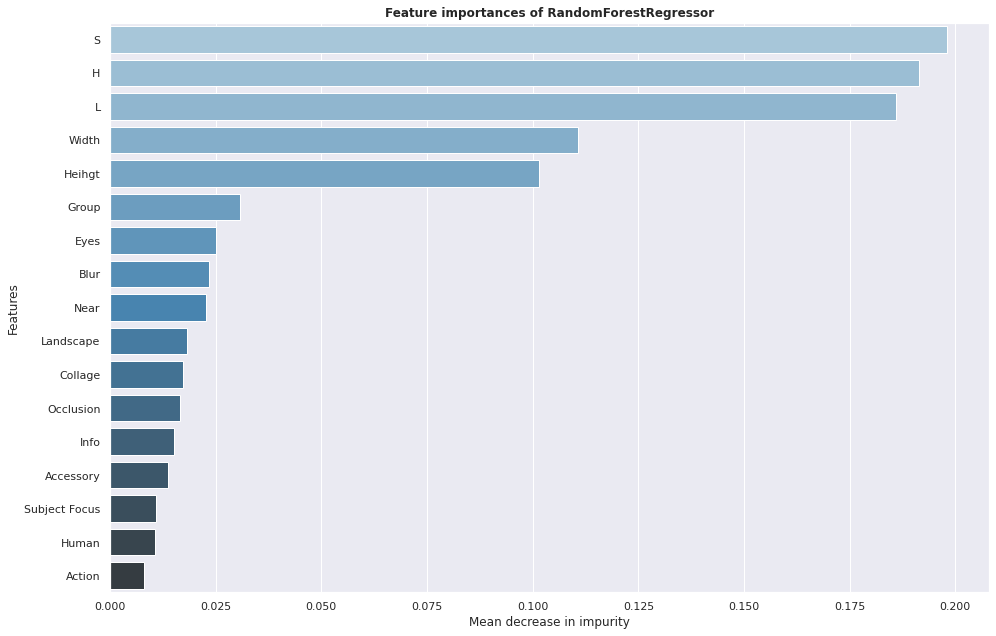

In [41]:
importances = best_reg.best_estimator_.feature_importances_

feature_names = X_train.columns
forest_importances = pd.DataFrame(importances, columns=["FI"], index=feature_names)
forest_importances = forest_importances.sort_values("FI", ascending=False)

fig, ax = plt.subplots()
sns.barplot(data=forest_importances, x = "FI", 
            y=forest_importances.index, ax=ax, 
            palette="Blues_d")
ax.set_title("Feature importances of RandomForestRegressor", fontweight='bold')
ax.set_xlabel("Mean decrease in impurity")
ax.set_ylabel("Features")
fig.tight_layout()

**Now let us use this random Forest model to perform prediction on the validation set**

In [42]:
pred_reg = best_reg.predict(X_valid)

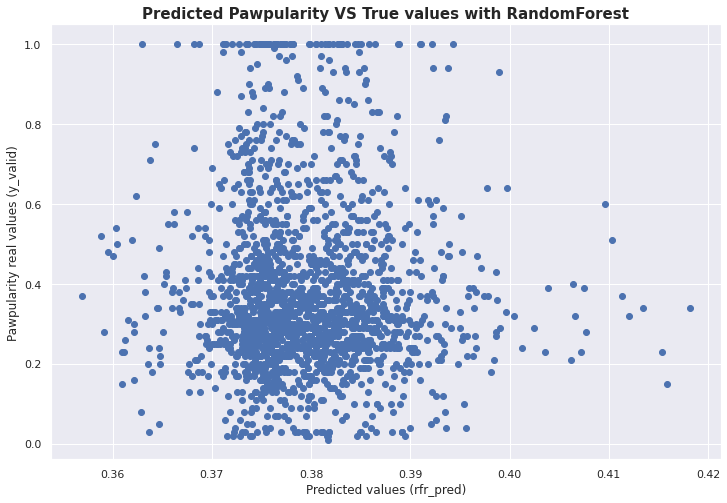

In [43]:
fig = plt.figure(figsize=(12,8))
plt.scatter(x=pred_reg, y=y_valid)
plt.ylabel("Pawpularity real values (y_valid)")
plt.xlabel("Predicted values (rfr_pred)")
plt.title("Predicted Pawpularity VS True values with RandomForest", 
          fontsize=15, fontweight='bold')
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error, r2_score

print(f"Mean Squared Error: {mean_squared_error(y_valid, pred_reg)}")
print(f"R Squared Score: {r2_score(y_valid, pred_reg)}")

Mean Squared Error: 0.04533353917049189
R Squared Score: -0.003101472360374613


From the above, especially the R-Squared score, it shows the model did very bad (Worst). This means the dataset alone is not enough predictor of popularity

**We will now use Image claffication with NASNetLarge**

In [45]:
# lad the Keras model NASNetLarge

nasnet_model = tf.keras.applications.NASNetLarge(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(299,299,3),
    pooling='avg'
)

nasnet_model.load_weights('../input/keras-applications-models/NASNetLarge.h5')

# Non trainable
nasnet_model.trainable = False

2021-12-16 07:55:33.534905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 07:55:33.678454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 07:55:33.679165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 07:55:33.680544: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

For better use in Keras, we will create generators by slightly modifying our DataFrame Pandas. We will indeed add the name (and extension) of the image files to our y DataSets.

In [46]:
k_df = train_df[["Id","Pawpularity"]]
k_df["Image"] = k_df["Id"].apply(lambda x: x+".jpg")
k_df["Pawpularity"] = k_df["Pawpularity"]/100
k_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Id  Pawpularity  \
0  0007de18844b0dbbb5e1f607da0606e0         0.63   
1  0009c66b9439883ba2750fb825e1d7db         0.42   
2  0013fd999caf9a3efe1352ca1b0d937e         0.28   
3  0018df346ac9c1d8413cfcc888ca8246         0.15   
4  001dc955e10590d3ca4673f034feeef2         0.72   

                                  Image  
0  0007de18844b0dbbb5e1f607da0606e0.jpg  
1  0009c66b9439883ba2750fb825e1d7db.jpg  
2  0013fd999caf9a3efe1352ca1b0d937e.jpg  
3  0018df346ac9c1d8413cfcc888ca8246.jpg  
4  001dc955e10590d3ca4673f034feeef2.jpg

In [47]:
k_X_train, k_X_valid, k_y_train, k_y_valid = train_test_split(
    k_df["Image"], k_df["Pawpularity"], 
    test_size=0.2, 
    random_state=38)

print(f"X_train : {k_X_train.shape}")
print(f"X_test : {k_X_valid.shape}")
print(f"y_train : {k_y_train.shape[0]}")
print(f"y_test : {k_y_valid.shape[0]}")

X_train : (7929,)
X_test : (1983,)
y_train : 7929
y_test : 1983


In [48]:
k_train_df = pd.DataFrame(k_X_train, columns=["Image"])
k_train_df["Pawpularity"] = k_y_train
k_valid_df = pd.DataFrame(k_X_valid, columns=["Image"])
k_valid_df["Pawpularity"] = k_y_valid

In [49]:
k_train_df.head()

Image  Pawpularity
17    006fe962f5f7e2c5f527b2e27e28ed6d.jpg         0.69
905   16e40a41007af24c4a7cf9bcde55ef1d.jpg         0.04
2922  4b792ec239070d4135b7a1bdcdcfea9f.jpg         0.47
8254  d5bdf3446e86ce4ec67ce7a00f1cccc2.jpg         0.27
3917  63f25a433a4cb122b60558a3c60aca25.jpg         0.22

In [50]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.nasnet.preprocess_input,
    validation_split=0.2)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.nasnet.preprocess_input)

In [51]:
train_generator = datagen.flow_from_dataframe(
    dataframe=k_train_df,
    directory=dataset_path+"train/",
    x_col="Image",
    y_col="Pawpularity",
    subset="training",
    target_size=(299,299),
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw")

valid_generator = datagen.flow_from_dataframe(
    dataframe=k_train_df,
    directory=dataset_path+"train/",
    x_col="Image",
    y_col="Pawpularity",
    subset="validation",
    target_size=(299,299),
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw")

test_generator = datagen.flow_from_dataframe(
    dataframe=k_valid_df,
    directory=dataset_path+"train/",
    x_col="Image",
    y_col="Pawpularity",
    target_size=(299,299),
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw")

Found 6344 validated image filenames.
Found 1585 validated image filenames.
Found 1983 validated image filenames.


In [52]:
# Add new fully-connected layers
base_output = nasnet_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
base_output = Dense(256, activation='relu')(base_output)
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
# Output : new classifier
predictions = Dense(1, activation='linear')(base_output)

# Define new model
my_nasnet_model = Model(inputs=nasnet_model.input, outputs=predictions)
my_nasnet_model.compile(optimizer="adam", loss=tf.keras.metrics.mean_squared_error)

In [53]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

# Early Stopping to prevent overfitting
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=15, 
    verbose=3, 
    restore_best_weights=True)


history_nasnet = my_nasnet_model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=50,
    verbose=2,
    callbacks=[early_stopper])

2021-12-16 07:55:52.292853: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-12-16 07:56:09.230103: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


198/198 - 170s - loss: 0.0507 - val_loss: 0.0384
Epoch 2/50
198/198 - 143s - loss: 0.0375 - val_loss: 0.0347
Epoch 3/50
198/198 - 143s - loss: 0.0350 - val_loss: 0.0352
Epoch 4/50
198/198 - 143s - loss: 0.0328 - val_loss: 0.0397
Epoch 5/50
198/198 - 143s - loss: 0.0307 - val_loss: 0.0351
Epoch 6/50
198/198 - 142s - loss: 0.0303 - val_loss: 0.0366
Epoch 7/50
198/198 - 144s - loss: 0.0294 - val_loss: 0.0355
Epoch 8/50
198/198 - 143s - loss: 0.0301 - val_loss: 0.0370
Epoch 9/50
198/198 - 139s - loss: 0.0286 - val_loss: 0.0362
Epoch 10/50
198/198 - 144s - loss: 0.0257 - val_loss: 0.0375
Epoch 11/50
198/198 - 143s - loss: 0.0251 - val_loss: 0.0388
Epoch 12/50
198/198 - 143s - loss: 0.0238 - val_loss: 0.0392
Epoch 13/50
198/198 - 143s - loss: 0.0230 - val_loss: 0.0400
Epoch 14/50
198/198 - 143s - loss: 0.0233 - val_loss: 0.0394
Epoch 15/50
198/198 - 142s - loss: 0.0220 - val_loss: 0.0383
Epoch 16/50
198/198 - 143s - loss: 0.0210 - val_loss: 0.0389
Epoch 17/50
198/198 - 139s - loss: 0.0196 - 

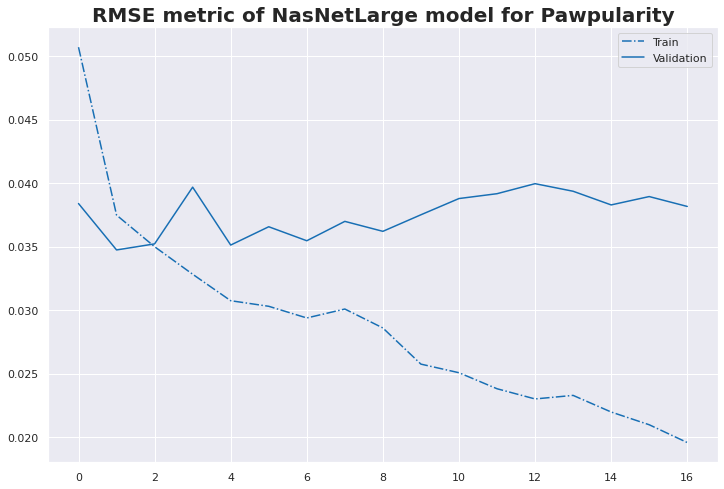

In [54]:
fig = plt.figure(figsize=(12, 8))
plt.plot(history_nasnet.history["loss"],
         color="#186fb4", linestyle="-.",
         label="Train")
plt.plot(history_nasnet.history["val_loss"],
         color="#186fb4",
         label="Validation")
plt.legend()
plt.title("RMSE metric of NasNetLarge model for Pawpularity", 
          fontsize=20, fontweight='bold')
plt.show()

From the above, we see a downward slope of the training loss but the validation barely dropped. Lets try predicting

In [55]:
nasnet_pred = my_nasnet_model.predict(test_generator)
nasnet_pred.shape

(1983, 1)

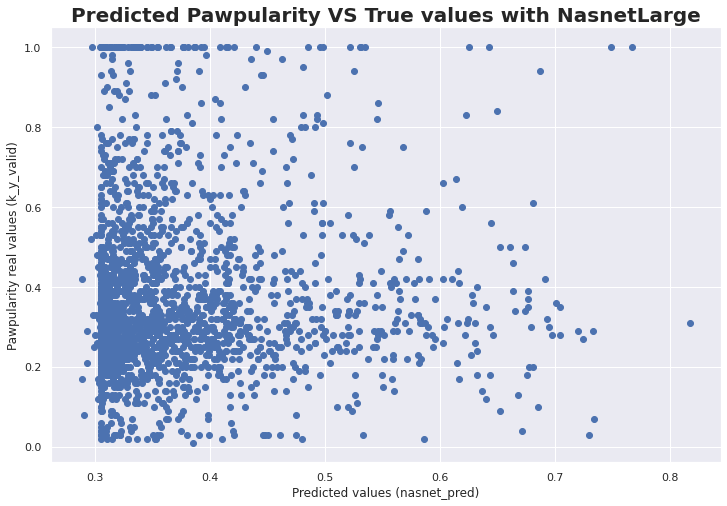

In [56]:
fig = plt.figure(figsize=(12,8))
plt.scatter(x=nasnet_pred, y=k_y_valid)
plt.ylabel("Pawpularity real values (k_y_valid)")
plt.xlabel("Predicted values (nasnet_pred)")
plt.title("Predicted Pawpularity VS True values with NasnetLarge", 
          fontsize=20, fontweight='bold')
plt.show()

In [57]:
print(f"R Squared Score: {r2_score(k_y_valid, nasnet_pred)}")

R Squared Score: -0.1524627487938257


Again from the above, the model did poorly (though better than the RandomForest Model). Hence the model alone is not enough to predict the target value.

We will now try optimizing our model 

# Transfer Learning Optimization

In [58]:
datagen_2 = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20, # rotation
    width_shift_range=0.2, # horizontal shift
    height_shift_range=0.2, # vertical shift
    zoom_range=0.2, # zoom
    horizontal_flip=True, # horizontal flip
    featurewise_std_normalization=True,
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    validation_split=0.2)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [59]:
train_generator_2 = datagen_2.flow_from_dataframe(
    dataframe=k_train_df,
    directory=dataset_path+"train/",
    x_col="Image",
    y_col="Pawpularity",
    subset="training",
    target_size=(299,299),
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw")

valid_generator_2 = datagen_2.flow_from_dataframe(
    dataframe=k_train_df,
    directory=dataset_path+"train/",
    x_col="Image",
    y_col="Pawpularity",
    subset="validation",
    target_size=(299,299),
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw")

Found 6344 validated image filenames.
Found 1585 validated image filenames.


In [60]:
STEP_SIZE_TRAIN = train_generator_2.n//train_generator_2.batch_size
STEP_SIZE_VALID = valid_generator_2.n//valid_generator_2.batch_size

In [61]:
tf.keras.backend.clear_session()
history_nasnet_2 = my_nasnet_model.fit(
    train_generator_2,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator_2,
    validation_steps=STEP_SIZE_VALID,
    epochs=50,
    verbose=2,
    callbacks=[early_stopper])

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
198/198 - 287s - loss: 0.0396 - val_loss: 0.0382
Epoch 2/50
198/198 - 282s - loss: 0.0390 - val_loss: 0.0359
Epoch 3/50
198/198 - 281s - loss: 0.0348 - val_loss: 0.0360
Epoch 4/50
198/198 - 283s - loss: 0.0344 - val_loss: 0.0347
Epoch 5/50
198/198 - 284s - loss: 0.0329 - val_loss: 0.0345
Epoch 6/50
198/198 - 284s - loss: 0.0332 - val_loss: 0.0354
Epoch 7/50
198/198 - 276s - loss: 0.0324 - val_loss: 0.0351
Epoch 8/50
198/198 - 278s - loss: 0.0312 - val_loss: 0.0355
Epoch 9/50
198/198 - 276s - loss: 0.0309 - val_loss: 0.0353
Epoch 10/50
198/198 - 279s - loss: 0.0308 - val_loss: 0.0344
Epoch 11/50
198/198 - 275s - loss: 0.0304 - val_loss: 0.0355
Epoch 12/50
198/198 - 270s - loss: 0.0307 - val_loss: 0.0351
Epoch 13/50
198/198 - 275s - loss: 0.0295 - val_loss: 0.0361
Epoch 14/50
198/198 - 274s - loss: 0.0294 - val_loss: 0.0353
Epoch 15/50
198/198 - 276s - loss: 0.0287 - val_loss: 0.0355
Epoch 16/50
198/198 - 276s - loss: 0.0287 - val_loss: 0.0346
Epoch 17/50
198/198 - 272s - loss

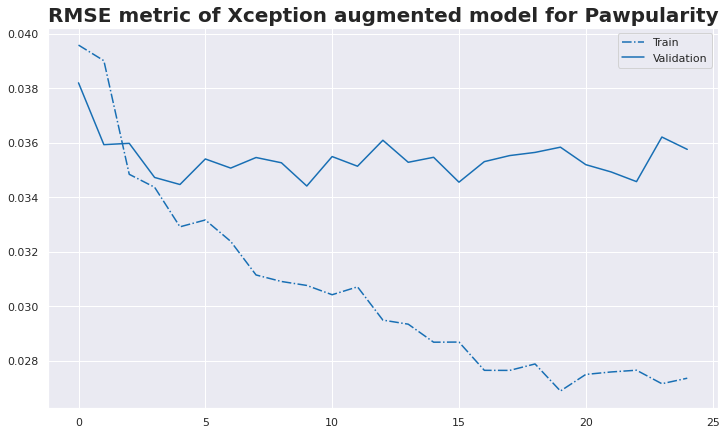

In [62]:
fig = plt.figure(figsize=(12, 7))
plt.plot(history_nasnet_2.history["loss"],
         color="#186fb4", linestyle="-.",
         label="Train")
plt.plot(history_nasnet_2.history["val_loss"],
         color="#186fb4",
         label="Validation")
plt.legend()
plt.title("RMSE metric of Xception augmented model for Pawpularity", 
          fontsize=20, fontweight='bold')
plt.show()

In [63]:
nasnet_pred_2 = history_nasnet_2.model.predict(test_generator)
nasnet_pred_2.shape

(1983, 1)

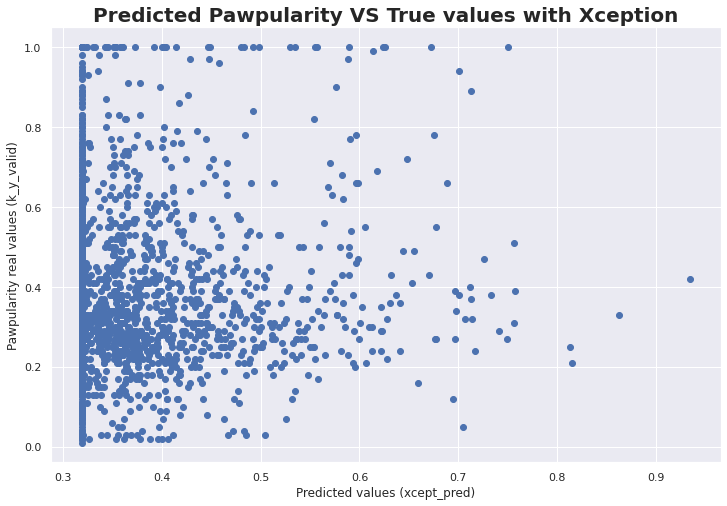

In [64]:
fig = plt.figure(figsize=(12,8))
plt.scatter(x=nasnet_pred_2, y=k_y_valid)
plt.ylabel("Pawpularity real values (k_y_valid)")
plt.xlabel("Predicted values (xcept_pred)")
plt.title("Predicted Pawpularity VS True values with Xception", 
          fontsize=20, fontweight='bold')
plt.show()

In [65]:
print(f"R Squared Score: {r2_score(k_y_valid, nasnet_pred_2)}")

R Squared Score: -0.12491819360371115


The augmented model looks a bit better but still fails to predict popularity scores reliably enough

# Hybrid approach with feature detection and RandomForest

We are therefore going to use a hybrid approach consisting in carrying out the feature detection with NASNetLarge, then in coupling the results with the database of image characteristics to finally predict y with a RandomForestRegressor.

In [66]:
def feature_detect_img(folder, img_size=299):
    listVectors = []
    for img in tqdm(os.listdir(dataset_path+folder+"/")):
        image = plt.imread(dataset_path+folder+"/"+img)
        #resize image if new dims provided
        image = cv2.resize(image, (img_size,img_size),
                           interpolation = cv2.INTER_AREA)
        image = np.expand_dims(image, axis=0)
        image = tf.keras.applications.nasnet.preprocess_input(image)
        
        img_vector = nasnet_model.predict(image)
        listVectors.append(np.array(img_vector))
    
    return listVectors

In [67]:
train_vectors_fd = feature_detect_img("train", img_size=299)

  0%|          | 0/9912 [00:00<?, ?it/s]

In [68]:
train_vectors_fd = np.array(train_vectors_fd)
train_vectors_fd = np.squeeze(train_vectors_fd)
train_vectors_fd.shape
train_vectors_fd = pd.DataFrame(train_vectors_fd)

In [69]:
hy_train_df = pd.concat([train_df,train_vectors_fd], axis=1)
hy_train_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  ...      4022      4023      4024  \
0          0      1        0      0  ...  0.079803  0.023971  0.501077   
1          0      0        0      0  ...  0.024843  0.128322  0.046713   
2          0      0        0      1  ...  0.077756  0.015934  0.100518   
3          0      0        0      0  ...  0.758681  0.143284  0.047059   
4          0      1        0      0  ...  0.612266  0.404041  0.106734   

       4025      4026      4027      4028      4029      4030      4031  
0  0.386691  0.032579  0.754077  0.004455  0.213716  0.044226  0.005437  
1  0.229031  0.322126  0.531269  0.196184  0.000000  0.095797  0.796435  
2  0.190945  0.016527  0.081857  0.114844  0.300977  0.000000  0.109510  
3  0.197330  0.471895  0.639916  0.317970  0.031265  0.229568  0.385479  
4  0.216689  0.012500  0.140358  0.918731  0.001602  0.126654  0.326214  

[5 rows x 4053 columns]

In [70]:
hy_train_df.columns

Index([           'Id', 'Subject Focus',          'Eyes',          'Face',
                'Near',        'Action',     'Accessory',         'Group',
             'Collage',         'Human',
       ...
                  4022,            4023,            4024,            4025,
                  4026,            4027,            4028,            4029,
                  4030,            4031],
      dtype='object', length=4053)

In [71]:
h_labels = hy_train_df["Id"]
h_y = hy_train_df["Pawpularity"]
h_X = hy_train_df.drop(["Id","Pawpularity", "Img"], axis=1)

# Normalization
encoder = MinMaxScaler()
encoder.fit(h_X)
h_X_scaled = encoder.transform(h_X)
h_X_scaled = pd.DataFrame(h_X_scaled, columns=h_X.columns)

h_X_train, h_X_valid, h_y_train, h_y_valid = train_test_split(
    h_X_scaled, h_y, test_size=0.3, random_state=38)

In [72]:
print(f"X_train : {h_X_train.shape}")
print(f"X_test : {h_X_valid.shape}")
print(f"y_train : {h_y_train.shape[0]}")
print(f"y_test : {h_y_valid.shape[0]}")

X_train : (6938, 4050)
X_test : (2974, 4050)
y_train : 6938
y_test : 2974


In [73]:
h_rfr = RandomForestRegressor(random_state=8)
param_grid = {
            "n_estimators" : [10,50, 75, 100, 150],
            "max_features" : ["log2", "sqrt"],
            "max_depth"    : [5,15,25, 35, 50],
            "bootstrap"    : [True, False]
        }

h_grid_rfr = GridSearchCV(
    h_rfr,
    param_grid,
    cv = 5,
    verbose=2,
    n_jobs=-1)

h_best_rfr = h_grid_rfr.fit(h_X_train, h_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


[CV] bootstrap=True, max_depth=5, max_features=log2, n_estimators=10 .
[CV]  bootstrap=True, max_depth=5, max_features=log2, n_estimators=10, total=   0.7s
[CV] bootstrap=True, max_depth=5, max_features=log2, n_estimators=10 .
[CV]  bootstrap=True, max_depth=5, max_features=log2, n_estimators=10, total=   0.6s
[CV] bootstrap=True, max_depth=5, max_features=log2, n_estimators=50 .
[CV]  bootstrap=True, max_depth=5, max_features=log2, n_estimators=50, total=   1.4s
[CV] bootstrap=True, max_depth=5, max_features=log2, n_estimators=50 .
[CV]  bootstrap=True, max_depth=5, max_features=log2, n_estimators=50, total=   1.4s
[CV] bootstrap=True, max_depth=5, max_features=log2, n_estimators=50 .
[CV]  bootstrap=True, max_depth=5, max_features=log2, n_estimators=50, total=   1.4s
[CV] bootstrap=True, max_depth=5, max_features=log2, n_estimators=75 .
[CV]  bootstrap=True, max_depth=5, max_features=log2, n_estimators=75, total=   2.0s
[CV] bootstrap=True, max_depth=5, max_features=log2, n_estimator

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 53.2min



[CV]  bootstrap=False, max_depth=5, max_features=sqrt, n_estimators=150, total=  29.6s
[CV] bootstrap=False, max_depth=15, max_features=log2, n_estimators=50 
[CV]  bootstrap=False, max_depth=15, max_features=log2, n_estimators=50, total=   5.2s
[CV] bootstrap=False, max_depth=15, max_features=log2, n_estimators=50 
[CV]  bootstrap=False, max_depth=15, max_features=log2, n_estimators=50, total=   5.0s
[CV] bootstrap=False, max_depth=15, max_features=log2, n_estimators=75 
[CV]  bootstrap=False, max_depth=15, max_features=log2, n_estimators=75, total=   7.4s
[CV] bootstrap=False, max_depth=15, max_features=log2, n_estimators=75 
[CV]  bootstrap=False, max_depth=15, max_features=log2, n_estimators=75, total=   8.0s
[CV] bootstrap=False, max_depth=15, max_features=log2, n_estimators=100 
[CV]  bootstrap=False, max_depth=15, max_features=log2, n_estimators=100, total=   9.5s
[CV] bootstrap=False, max_depth=15, max_features=log2, n_estimators=100 
[CV]  bootstrap=False, max_depth=15, max_f

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 103.8min finished


In [74]:
print(f"The best parameters for Randomforest: {h_best_rfr.best_params_}")

The best parameters for Randomforest: {'bootstrap': True, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 150}


In [75]:
h_rfr_pred = h_best_rfr.predict(h_X_valid)

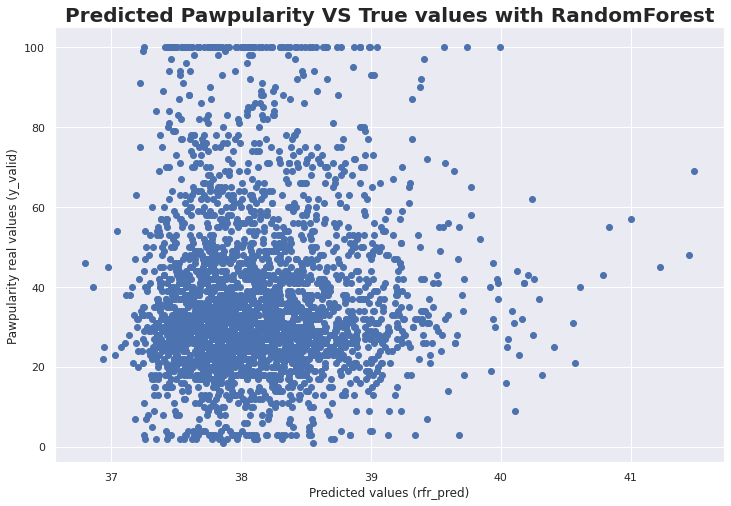

In [76]:
fig = plt.figure(figsize=(12,8))
plt.scatter(x=h_rfr_pred, y=h_y_valid)
plt.ylabel("Pawpularity real values (y_valid)")
plt.xlabel("Predicted values (rfr_pred)")
plt.title("Predicted Pawpularity VS True values with RandomForest", 
          fontsize=20, fontweight='bold')
plt.show()

In [83]:
print(f"R Squared Score: {r2_score(h_y_valid, h_rfr_pred)}")

R Squared Score: 0.00018305578991506533


In [77]:
submission_df = pd.read_csv("".join([dataset_path,"test.csv"]))
submission_df = submission_df[["Id"]]
submission_df["Image"] =  submission_df["Id"].apply(lambda x: x+".jpg")

submission_generator = test_datagen.flow_from_dataframe(
    dataframe=submission_df,
    directory=dataset_path+"test/",
    x_col="Image",
    y_col=None,
    target_size=(299,299),
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None)

Found 8 validated image filenames.


In [78]:
submission_pred = my_nasnet_model.predict(submission_generator)
submission_pred.shape

(8, 1)

In [79]:
test_vectors_fd = feature_detect_img("test", img_size=299)

  0%|          | 0/8 [00:00<?, ?it/s]

In [80]:
test_vectors_fd = np.array(test_vectors_fd)
test_vectors_fd = np.squeeze(test_vectors_fd)
test_vectors_fd.shape
test_vectors_fd = pd.DataFrame(test_vectors_fd)

In [81]:
hy_test_df = pd.concat([test_df,test_vectors_fd], axis=1)
hy_test_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  4128bae22183829d2b5fea10effdb0c3              1     0     1     0       0   
1  43a2262d7738e3d420d453815151079e              0     1     0     0       0   
2  4e429cead1848a298432a0acad014c9d              0     0     0     1       0   
3  80bc3ccafcc51b66303c2c263aa38486              1     0     1     0       0   
4  8f49844c382931444e68dffbe20228f4              1     1     1     0       1   

   Accessory  Group  Collage  Human  ...      4022      4023      4024  \
0          1      1        0      0  ...  0.272054  0.331767  0.017480   
1          0      1        1      0  ...  0.114094  0.183464  0.010896   
2          1      1        1      0  ...  0.144813  0.206639  0.000000   
3          0      0        0      0  ...  0.241374  0.197718  0.000000   
4          1      0        1      0  ...  0.201486  0.193038  0.005178   

       4025      4026      4027      4028      4029      4030      4031  
0  0.021086  0.372953  0.170858  0.006173  0.523534  0.018887  0.019938  
1  0.011173  0.293789  0.124873  0.000000  0.645491  0.020884  0.000000  
2  0.015484  0.361324  0.286627  0.000000  0.325281  0.030737  0.037737  
3  0.003201  0.261788  0.225609  0.000000  0.517262  0.035821  0.003341  
4  0.007008  0.313372  0.311257  0.001343  0.575347  0.000437  0.000000  

[5 rows x 4052 columns]

In [84]:
hy_test_df["Img"]

0    /kaggle/input/petfinder-pawpularity-score/test...
1    /kaggle/input/petfinder-pawpularity-score/test...
2    /kaggle/input/petfinder-pawpularity-score/test...
3    /kaggle/input/petfinder-pawpularity-score/test...
4    /kaggle/input/petfinder-pawpularity-score/test...
5    /kaggle/input/petfinder-pawpularity-score/test...
6    /kaggle/input/petfinder-pawpularity-score/test...
7    /kaggle/input/petfinder-pawpularity-score/test...
Name: Img, dtype: object

In [85]:
h_test_labels = hy_test_df["Id"]
h_X_test = hy_test_df.drop(["Id", "Img"], axis=1)
h_X_test_scaled = encoder.transform(h_X_test)
h_X_test_scaled = pd.DataFrame(h_X_test_scaled, columns=h_X_test.columns)

In [86]:
submission_pred = h_best_rfr.predict(h_X_test_scaled)

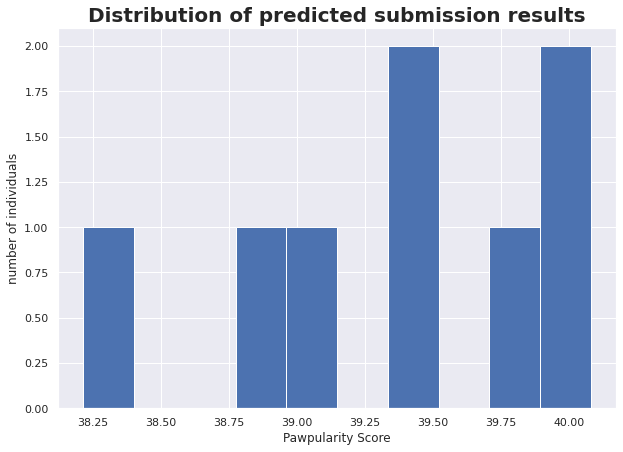

In [87]:
fig = plt.figure(figsize=(10,7))
plt.hist((submission_pred))
plt.xlabel("Pawpularity Score")
plt.ylabel("number of individuals")
plt.title("Distribution of predicted submission results", 
          fontsize=20, fontweight='bold')
plt.show()

In [88]:
submission_df["Pawpularity"] = (submission_pred)
submission_df = submission_df[["Id","Pawpularity"]]
submission_df.head()

Id  Pawpularity
0  4128bae22183829d2b5fea10effdb0c3    39.707335
1  43a2262d7738e3d420d453815151079e    39.371027
2  4e429cead1848a298432a0acad014c9d    38.215865
3  80bc3ccafcc51b66303c2c263aa38486    38.899727
4  8f49844c382931444e68dffbe20228f4    39.515670

In [89]:
submission_df.to_csv("submission.csv", sep=",", index=False)